In [1]:
# ==================== Testing traj-avg Observables ====================
# This notebook tests the trajectory-averaged observables from multiple G(t) histories.
# Imports & hot-reload

import os, importlib, numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import pandas as pd

import classA_U1FGTN as mod
importlib.reload(mod)
from classA_U1FGTN import classA_U1FGTN

In [2]:
# parameters (DW = True)
Nx, Ny   = 16, 16
Ntot = 4*Nx*Ny
Nlayer = Ntot//2
cycles   = 20
samples  = 100
nshell   = None               # None for untruncated
DW       = True
model = classA_U1FGTN(Nx, Ny, DW=DW)
DW_loc = model.DW_loc


DWs at x=(4, 11)
------------------------- classA_U1FGTN Initialized -------------------------


In [3]:
def unflatten_G(Gfull, Nx, Ny, top=True):
    """Accept (..., Ntot, Ntot) and return (..., Nx, Ny, 2, Nx, Ny, 2)."""
    Gfull = np.asarray(Gfull)
    leading = Gfull.shape[:-2]
    Nlayer = 2 * Nx * Ny
    if top and Gfull.shape[-2:] != (Nlayer, Nlayer):
        raise ValueError(f"Expected (...,{Nlayer},{Nlayer}), got {Gfull.shape}")

    # (..., μ, x, y, ν, x', y')
    G6m = Gfull.reshape(leading + (2, Nx, Ny, 2, Nx, Ny), order='F')

    base = len(leading)
    axes = list(range(base)) + [
        base + 1,  # x
        base + 2,  # y
        base + 0,  # μ
        base + 4,  # x'
        base + 5,  # y'
        base + 3,  # ν
    ]
    return np.transpose(G6m, axes)


def flatten_G(G6):
    """
    Flatten G(x, y, μ; x', y', ν) -> G_flat with index
        i = μ + 2*x + 2*Nx*y   (Fortran order on (μ, x, y)),
    supporting any leading batch dimensions.

    Input shape: (..., Nx, Ny, 2, Nx, Ny, 2)
    Output shape: (..., 2*Nx*Ny, 2*Nx*Ny)
    """
    G6 = np.asarray(G6, dtype=np.complex128)
    if G6.ndim < 6:
        raise ValueError(f"G must have at least 6 dims; got {G6.shape}")

    leading = G6.shape[:-6]
    Nx, Ny, s1, Nx2, Ny2, s2 = G6.shape[-6:]
    if not ((s1, s2) == (2, 2) and (Nx, Ny) == (Nx2, Ny2)):
        raise ValueError(
            f"G must have shape (..., Nx, Ny, 2, Nx, Ny, 2); got {G6.shape}"
        )

    base = len(leading)
    axes = list(range(base)) + [
        base + 2,  # μ
        base + 0,  # x
        base + 1,  # y
        base + 5,  # ν
        base + 3,  # x'
        base + 4,  # y'
    ]
    G6m = np.transpose(G6, axes)
    flat_shape = leading + (2 * Nx * Ny, 2 * Nx * Ny)
    return G6m.reshape(flat_shape, order="F")

In [4]:

def replace_covariance_blocks_with_maxmix(G, x_coords, y_coords, Nx=None, Ny=None):
    """
    Zero out the lattice modes (and all cross terms) specified by 1-based coordinates.
    Works with either:
      • G.shape == (Nx, Ny, 2, Nx, Ny, 2)            (top layer tensor)
      • G.shape == (2*Nx*Ny, 2*Nx*Ny)               (flattened top layer)
      • G.shape == (4*Nx*Ny, 4*Nx*Ny)               (full two-layer covariance)
    For 2D inputs, supply Nx and Ny so the mode indexing can be inferred.
    """
    G = np.asarray(G, dtype=np.complex128)
    x_arr = np.asarray(list(x_coords), dtype=int)
    y_arr = np.asarray(list(y_coords), dtype=int)
    if x_arr.shape != y_arr.shape:
        raise ValueError("x_coords and y_coords must have the same shape.")

    def _collect_coords(x_in, y_in, Nx, Ny):
        coords, seen = [], set()
        for x1, y1 in zip(x_in.flat, y_in.flat):
            if not (1 <= x1 <= Nx) or not (1 <= y1 <= Ny):
                raise ValueError(f"Coordinate {(int(x1), int(y1))} out of bounds for 1-based lattice ({Nx}, {Ny}).")
            key = (int(x1) - 1, int(y1) - 1)
            if key not in seen:
                seen.add(key)
                coords.append(key)
        return coords

    def _selected_indices(coords, Nx, Ny, layer_offset=0, layer_span=0):
        sel = []
        shift = layer_offset * layer_span
        for x0, y0 in coords:
            base = 2 * (x0 + Nx * y0) + shift
            sel.extend((base, base + 1))
        return np.asarray(sel, dtype=int)

    def _apply_zero_fill(mat, selected):
        if selected.size == 0:
            return np.array(mat, copy=True)
        total = mat.shape[0]
        mask = np.ones(total, dtype=bool)
        mask[selected] = False
        remaining = np.nonzero(mask)[0]
        out = np.zeros_like(mat)
        out[np.ix_(remaining, remaining)] = mat[np.ix_(remaining, remaining)]
        return out

    if G.ndim == 6:
        Nx6, Ny6, s1, Nx2, Ny2, s2 = G.shape
        if (s1, s2) != (2, 2) or (Nx6, Ny6) != (Nx2, Ny2):
            raise ValueError(f"Incompatible covariance shape {G.shape}; expected (Nx, Ny, 2, Nx, Ny, 2).")
        coords = _collect_coords(x_arr, y_arr, Nx6, Ny6)
        if not coords:
            return np.array(G, copy=True)
        selected = _selected_indices(coords, Nx6, Ny6)
        flat = flatten_G(G)
        flat_new = _apply_zero_fill(flat, selected)
        return unflatten_G(flat_new, Nx=Nx6, Ny=Ny6, top=True)

    if G.ndim == 2:
        if G.shape[0] != G.shape[1]:
            raise ValueError("Covariance must be square.")
        if Nx is None or Ny is None:
            raise ValueError("Provide Nx and Ny for 2D covariance inputs.")
        coords = _collect_coords(x_arr, y_arr, Nx, Ny)
        if not coords:
            return np.array(G, copy=True)
        total = G.shape[0]
        top_modes = 2 * Nx * Ny

        if total == top_modes:
            selected = _selected_indices(coords, Nx, Ny)
            return _apply_zero_fill(G, selected)

        if total == 2 * top_modes:
            selected = _selected_indices(coords, Nx, Ny)  # top layer occupies the first block
            return _apply_zero_fill(G, selected)

        raise ValueError(f"Matrix dimension {total} incompatible with Nx={Nx}, Ny={Ny} (expected 2*Nx*Ny or 4*Nx*Ny).")

    raise ValueError("G must be either a 6D tensor or a 2D square matrix.")


In [6]:
data = np.load('cache/G_history_samples/N16x16_C20_S100_nshNone_DW1_init-default.npz', allow_pickle=True)
G = unflatten_G(data[data.files[0]][...,:Nlayer,:Nlayer], Nx, Ny)
print(G.shape, G.dtype) # G will denote the steady-state of the complex covariance with DWs

(100, 20, 16, 16, 2, 16, 16, 2) complex128


In [5]:
def entanglement_contour_from_G6(G6):
    """Return s(x,y) for (..., Nx, Ny, 2, Nx, Ny, 2) covariances."""
    G6 = np.asarray(G6, dtype=np.complex128)
    if G6.ndim < 6:
        raise ValueError(f"G must have at least 6 dims; got {G6.shape}")

    Nx, Ny = G6.shape[-6], G6.shape[-5]
    leading = G6.shape[:-6]
    dim = 2 * Nx * Ny

    # flatten -> hermitise -> eigendecompose
    Gflat = flatten_G(G6)                                   # (..., dim, dim)
    Gflat = 0.5 * (Gflat + np.swapaxes(Gflat.conj(), -1, -2))
    evals, vecs = np.linalg.eigh(Gflat)
    evals_2pt = (1/2)*(evals+1) # covert to two point from complex covar
    evals_2pt = np.clip(np.real_if_close(evals_2pt), 1e-12, 1 - 1e-12)
    weights = -(evals_2pt * np.log(evals_2pt) + (1 - evals_2pt) * np.log(1 - evals_2pt))

    diagF = np.einsum("...ik,...k,...ik->...i", vecs, weights, vecs.conj(), optimize=True).real

    # reshape diag back to (μ, x, y), then sum over μ
    diagF = diagF.reshape(leading + (2, Nx, Ny), order="F")
    return diagF.sum(axis=-3)


ValueError: The number of FixedLocator locations (16), usually from a call to set_ticks, does not match the number of labels (8).

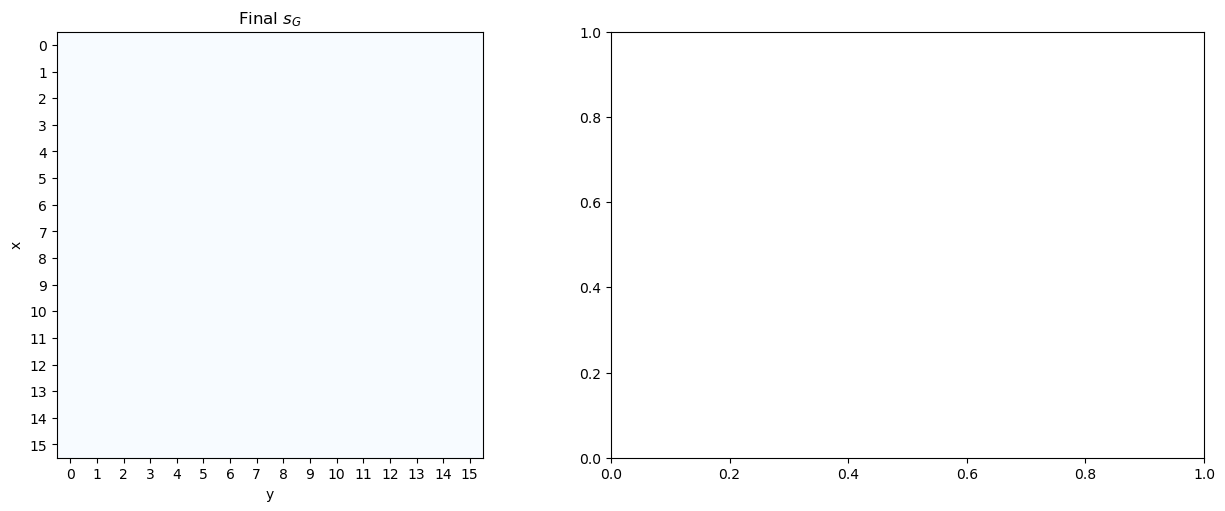

In [8]:
G_final = G[0,-1,...]
contour_G = entanglement_contour_from_G6(G_final)
G_prime = replace_covariance_blocks_with_maxmix(G_final, x_coords=[1], y_coords=[1])
contour_G_prime = entanglement_contour_from_G6(G_prime)

Nx, Ny = contour_G.shape
vmin = min(np.min(contour_G), np.min(contour_G_prime))
vmax = max(np.max(contour_G), np.max(contour_G_prime))

fig = plt.figure(constrained_layout=True, figsize=(12.5, 5.0))
gs = fig.add_gridspec(nrows=1, ncols=2)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]

for ax, data, title in zip(
    axes,
    (contour_G, contour_G_prime),
    ("Final $s_G$", "Final $s_{G'}$ (max-mix at 1,1)"),
):
    im = ax.imshow(
        data,
        cmap="Blues",
        origin="upper",
        aspect="equal",
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_title(title)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    ax.set_xticks(np.arange(Ny))
    ax.set_yticks(np.arange(Nx))
    ax.set_xticklabels(np.arange(0, Ny, 2))
    ax.set_yticklabels(np.arange(0, Nx, 2))
    ax.set_xticks(np.arange(-0.5, Ny, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, Nx, 1), minor=True)
    ax.grid(which="minor", color="k", linestyle="-", linewidth=0.6, alpha=0.3)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="s(x,y)")

plt.show()

In [ ]:
# --- Build the modified steady state ---
G_final_full = G[0, -1].astype(np.complex128)  # final full-layer covariance (4*Nx*Ny x 4*Nx*Ny)
Nx = model.Nx
Ny = model.Ny

# DW_loc is stored 0-based inside the model; convert to 1-based for the helper
x_targets = [int(model.DW_loc[0]) + 1, int(model.DW_loc[1]) + 1]
y_targets = [1, Ny]  # inject at y = 1 and y = Ny (1-based)

G_prime_full = replace_covariance_blocks_with_maxmix(
    G_final_full,
    x_coords=x_targets,
    y_coords=y_targets,
    Nx=Nx,
    Ny=Ny,
)

# --- Run the adaptive circuit from the modified snapshot ---
rac_result = model.run_adaptive_circuit(
    G_history=True,
    cycles=20,
    samples=1,
    progress=False,
    parallelize_samples=False,
    store="full",
    init_mode="default",
    G_init=G_prime_full,
)
G_hist_prime = rac_result["G_hist"]  # shape (1, T, Ntot, Ntot)

# --- Entanglement-contour analysis on the new trajectory ---
model.entanglement_contour_suite(G_hist_prime, save=False)


In [6]:
data = np.load('cache/G_history_samples/N16x16_C20_S1_nshNone_DW1_init-default_store-full_DW_mixed_injection_xtargets=4-11-7.npz',allow_pickle=True)
G = data[data.files[0]]
print(G.shape)

(1, 21, 1024, 1024)


In [7]:
G_top = unflatten_G(G[0,:,:Nlayer,:Nlayer], Nx, Ny)
print(G_top.shape)
s = entanglement_contour_from_G6(G_top)
print(s.shape)

(21, 16, 16, 2, 16, 16, 2)
(21, 16, 16)


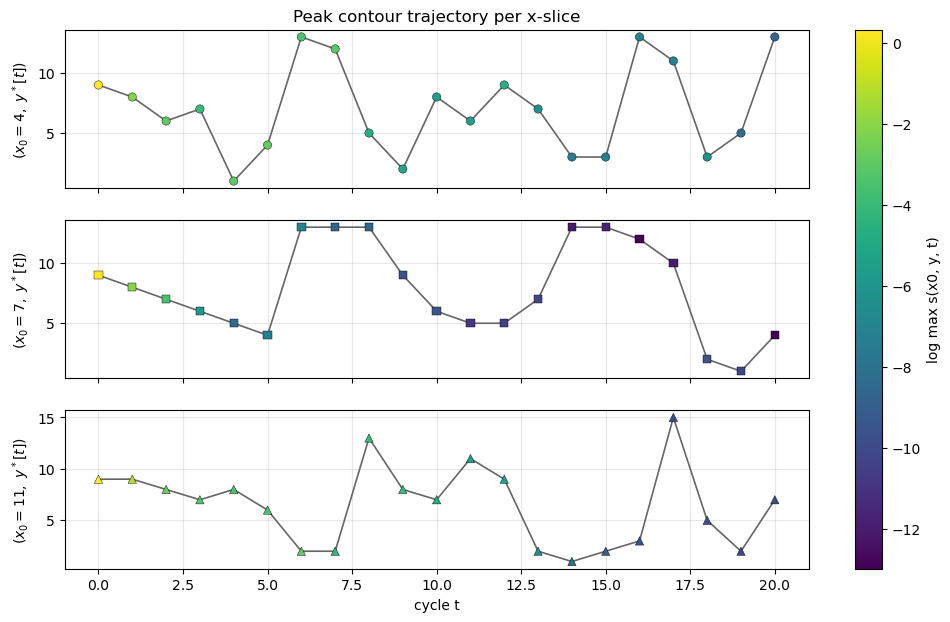

In [16]:
target_x = np.array([4, 7, 11])
markers = {4: "o", 7: "s", 11: "^"}

G_top = unflatten_G(G[0, :, :Nlayer, :Nlayer], Nx, Ny)   # (T, Nx, Ny, 2, Nx, Ny, 2)
s_txy = entanglement_contour_from_G6(G_top)                   # (T, Nx, Ny)
cycles = np.arange(s_txy.shape[0])

y_star = np.empty((target_x.size, cycles.size), dtype=int)
s_max = np.empty_like(y_star, dtype=float)

for i, x0 in enumerate(target_x):
    slice_data = s_txy[:, x0, :]
    argmax_y = np.argmax(slice_data, axis=-1)
    y_star[i] = argmax_y + 1                                # convert to 1-based indexing
    s_max[i] = np.take_along_axis(slice_data, argmax_y[:, None], axis=1).ravel()

fig, axes = plt.subplots(target_x.size, 1, figsize=(12, 7), sharex=True)
norm = plt.Normalize(np.log(np.maximum(s_max.min(), 1e-12)), np.log(s_max.max()))
cmap = plt.cm.viridis

for ax, x0, y_vals, s_vals in zip(axes, target_x, y_star, s_max):
    colors = np.log(np.maximum(s_vals, 1e-12))
    sc = ax.scatter(cycles, y_vals,
                    c=colors, cmap=cmap, norm=norm,
                    marker=markers[x0], edgecolors="k", linewidths=0.3,
                    zorder=3, label=f"x={x0}")
    ax.plot(cycles, y_vals, color="0.4", linewidth=1.2, zorder=2)
    ax.set_ylabel(rf"$(x_0={x0}, \ y^*[t])$")
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("cycle t")
axes[0].set_title("Peak contour trajectory per x-slice")
fig.colorbar(sc, ax=axes, label="log max s(x0, y, t)")
plt.show()

